In [136]:
# using OptimalTransport
# using ExactOptimalTransport
# import ExactOptimalTransport:discretemeasure
# using Distributions
# using Distances
# using Plots
# using Tulip
# using StatsPlots

# using LinearAlgebra
# using Random
# using Flux

# Random.seed!(1234)

MersenneTwister(1234)

In [1]:
# # 1D Cases
#
# The 1D case in Optimal Transport is a special case where one can
# easily obtain closed form solutions efficiently
# when the cost function is convex. In this situation,
# one does no need to use Linear Programming solvers
# to obtain the exact solution to the problem.

# ## Packages
#
# We load the following packages into our environment:

using OptimalTransport
using Distances
using Distributions
using StatsPlots

using LinearAlgebra
using Random

Random.seed!(1234)

# ## Continuous Distribution
#
# In the 1D case, when the source measure $\mu$ is continuous and the cost function
# has the form ``c(x, y) = h(|x - y|)`` where ``h`` is a convex function,
# the optimal transport plan is the Monge map
# ```math
# T = F_\\nu^{-1} \\circ F_\\mu
# ```
# where ``F_\\mu`` is the cumulative distribution function of `μ` and ``F_\\nu^{-1}`` is the
# quantile function of `ν`.
# In this setting, the optimal transport cost can be computed as
# ```math
# \\int_0^1 c(F_\\mu^{-1}(x), F_\\nu^{-1}(x)) \\mathrm{d}x
# ```
# where ``F_\\mu^{-1}`` and ``F_\\nu^{-1}`` are the quantile functions of `μ` and `ν`,
# respectively.
# 
# We start by defining the distributions.

μ = Normal(0, 1)

N = 10
ν = Poisson(N)

# Nest, we define a cost function.
c(x, y) = (abs(x - y))^2 # could have used `sqeuclidean` from `Distances.jl`

T = ot_plan(c, μ, ν)

# `T` is the Monge Map. Let's visualize it.
p1 = plot(μ; label='μ')
p1 = plot!(ν; marker=:circle, label='ν')
p2 = plot(-2:0.1:2, T(-2:0.1:2); label="Monge map", color=:green, legend=:topleft)
plot(p1, p2)

# The optimal transport cost can be computed with
ot_cost(c, μ, ν)

# If instead you want the 2-Wasserstein distance (which is the square root
# of the optimal transport with the Square Euclidean distatce, then use
wasserstein(μ, ν; p=2)

# ## Finite Discrete Distributions
#
# If the source and target measures are 1D finite discrete distributions
# (sometimes referred as empirical distributions, or as sample distributions),
# and if the cost function is convex, then the optimal
# transport plan can be written as a sorting algorithm,
# where the utmost left probability mass of the source is transported
# to the closest probability mass of the target, until everything is transported.
# 
# Define your measures as DiscreteNonParametric, which is a type in Distributions.jl.
# Also, let's assume both point masses with equal weights and let's
# use the `sqeuclidean` function instead of creating our own cost function.

M = 15
μ = DiscreteNonParametric(1.5rand(M), fill(1 / M, M))

N = 10
ν = DiscreteNonParametric(1.5rand(N) .+ 2, fill(1 / N, N))

γ = ot_plan(sqeuclidean, μ, ν);

# This time γ is a sparse matrix containing the transport plan. Let's visualize the results.
# We create a function `curve` just as a helper to draw the transport plan.

function curve(x1, x2, y1, y2)
    a = min(y1, y2)
    b = (y1 - y2 + a * (x1^2 - x2^2)) / (x1 - x2)
    c = y1 + a * x1^2 - b * x1
    f(x) = -a * x^2 + b * x + c
    return f
end

p = plot(μ; marker=:circle, label='μ')
p = plot!(ν; marker=:circle, label='ν', ylims=(0, 0.2))
for i in 1:M, j in 1:N
    if γ[i, j] > 0
        transport = curve(μ.support[i], ν.support[j], 1 / M, 1 / N)
        x = range(μ.support[i], ν.support[j]; length=100)
        p = plot!(x, transport.(x); color=:green, label=nothing, alpha=0.5)
    end
end
p

# Again, the optimal transport cost can be calculated with

ot_cost(sqeuclidean, μ, ν)


4.837025428947853

In [137]:
M = 200
μ = fill(1 / M, M)
μsupport = rand(M)

N = 250
ν = fill(1 / N, N)
νsupport = rand(N);

In [27]:
C = pairwise(SqEuclidean(), μsupport', νsupport'; dims=2);

In [28]:
γ = emd(μ, ν, C, Tulip.Optimizer());

In [29]:
emd2(μ, ν, C, Tulip.Optimizer())

0.0006423893452596201

In [31]:
μ = Distributions.DiscreteNonParametric(randn(10),normalize(ones(10),1))
ν = Distributions.DiscreteNonParametric(randn(20),normalize(ones(20),1));

In [263]:
M = 15
μ = DiscreteNonParametric(1.5rand(M), fill(1 / M, M))

N = 10
ν = DiscreteNonParametric(1.5rand(N).+2, fill(1 / N, N))

γ = ot_plan(sqeuclidean, μ, ν);

In [264]:
    function curve(x1,x2,y1, y2)
        a = min(y1,y2) 
        b = (y1 - y2 + a*(x1^2 - x2^2))/(x1-x2)
        c = y1 + a*x1^2 - b* x1
        f(x) = -a*x^2 + b*x +c 
        return f
    end


curve (generic function with 3 methods)

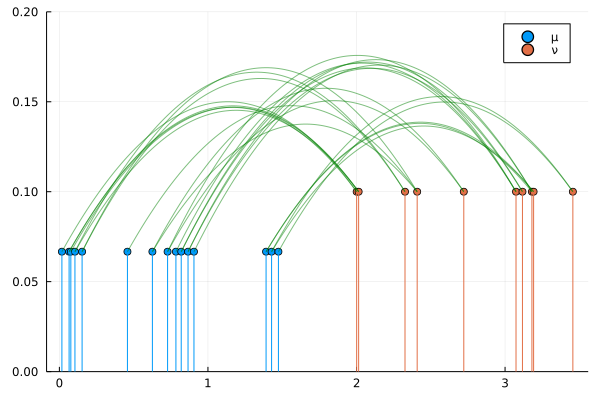

In [265]:
p = plot(μ, marker=:circle, label='μ')
p = plot!(ν, marker=:circle, label='ν', ylims=(0,0.2))
for i in 1:M, j in 1:N
    if γ[i,j] > 0
        transport = curve(μ.support[i], ν.support[j],1/M,1/N)
        x = range(μ.support[i], ν.support[j],length=100)
        p = plot!(x,transport.(x), color=:green, label=nothing, alpha=0.5)
    end
end
p

In [129]:
μ = Normal(0,1)

N = 10
ν = Poisson(N)

c(x,y) = (abs(x-y))^2 
T = ot_plan(sqeuclidean,μ,ν)

(::ExactOptimalTransport.var"#T#10"{Normal{Float64}, Poisson{Float64}}) (generic function with 1 method)

In [134]:
ot_cost(c, μ, ν)

104.72027014853339

In [135]:
wasserstein(μ, ν, p=2)

10.233292243874079

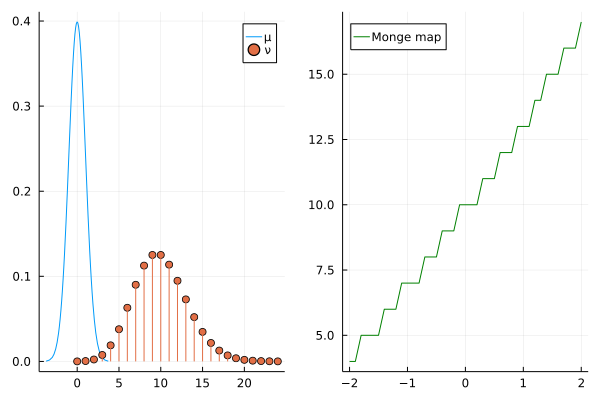

In [127]:
p1 = plot(μ, label='μ')
p1 = plot!(ν, marker=:circle, label='ν')
p2 = plot(-2:0.1:2,T(-2:0.1:2),label="Monge map",color=:green,legend =:topleft)
plot(p1,p2)

In [21]:
# μ = OptimalTransport.discrete(randn(10))
μ = discretemeasure([0, 1, 3])
ν = discretemeasure([5, 6, 8])

DiscreteNonParametric{Int64, Float64, Vector{Int64}, Vector{Float64}}(support=[5, 6, 8], p=[0.3333333333333333, 0.3333333333333333, 0.3333333333333333])

In [19]:
wasserstein(μ, ν, p=2)
squared2wasserstein(μ, ν)

24.999999999999996